Базовый эксперимент с RNN, с вариационным выводом

В качестве априоного рассматривается распредедение $\mathcal{N}(\mathbf{0}, 1000\mathbf{I})$,
в качестве вариационного --- $\mathcal{N}(\mathbf{m}, \beta \mathbf{I})$.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
from sklearn.metrics import f1_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(rc={"figure.figsize": (8, 6.5)})
sns.set(rc={"figure.figsize": (12, 10.8)})
from sklearn.externals import joblib
if theano.config.device == 'gpu':
    from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
else:
    from theano.tensor.shared_randomstreams import RandomStreams

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 740M (CNMeM is disabled, cuDNN not available)


In [2]:
fx = theano.config.floatX
suffix = 'D_I'

plt.style.use('classic')
mpl.rcParams['savefig.format'] = 'pdf'

border = 20

Делим выборку в отношении 85%/15%.

In [3]:
X = np.load('semeval_x.npy')
Y= np.load('semeval_y.npy').astype(np.int32)

part = int(len(Y)*0.85)

max_len = max([len(x) for x in X])
X_masked1,X_masked2  = np.zeros((Y.shape[0], max_len, 50)).astype(fx),np.zeros((Y.shape[0], max_len, 50)).astype(fx)
Mask1, Mask2 = np.zeros((Y.shape[0], max_len)).astype(fx), np.zeros((Y.shape[0], max_len)).astype(fx)
for i in range(X.shape[0]//2):
    X_masked1[i, :len(X[2*i])] = X[2*i]
    X_masked2[i, :len(X[2*i+1])] = X[2*i+1]
    Mask1[i,  :len(X[2*i])] = 1.0
    Mask2[i,  :len(X[2*i+1])] = 1.0
    
X_train1, X_test1=X_masked1[:part],  X_masked1[part:],
X_train2, X_test2 = X_masked2[:part],X_masked2[part:]

M_train1, M_test1= Mask1[:part], Mask1[part:],
M_train2, M_test2  = Mask2[:part],Mask2[part:]
Y_train,  Y_test = Y[:part], Y[part:]

Инициализируем переменные:

In [4]:
prior_log_sigma = theano.shared((np.log(10)).astype(fx))
prior_mu = theano.shared(np.array(0.0).astype(fx))

lr = theano.shared(np.array(0.05).astype(fx))
hidden_size = 50
input_size = 50

Создание входных тензоров.

Для каждой группы параметров из модели создаем переменную <название группы>_mean. В терминах Graves - наше вариационное распределение выглядит как:
Q([W_mean, U_mean, b_mean, ...], $e^\text{var_log_sigma}$)

Использовани логарифма в отклонении помогает избежать возможных переполнений и пр.

In [5]:
shape_W = (input_size,hidden_size)
shape_U = (hidden_size,hidden_size)
shape_b = (hidden_size)
shape_h0 = (hidden_size)
shape_W_softmax = (2*hidden_size,6)
shape_b_softmax = (6)

len_W = shape_W[0]*shape_W[1]; len_W_start = 0
len_U = shape_U[0]*shape_U[1]; len_U_start = len_W_start + len_W
len_b = shape_b; len_b_start = len_U_start + len_U
len_h0 = shape_h0; len_h0_start = len_b_start + len_b
len_W_softmax = shape_W_softmax[0]*shape_W_softmax[1]; len_W_softmax_start = len_h0_start + len_h0
len_b_softmax = shape_b_softmax; len_b_softmax_start = len_W_softmax_start + len_W_softmax

len_flatten = len_W + len_U + len_b + len_h0 + len_W_softmax + len_b_softmax

In [6]:
len_flatten

5706

In [7]:
var_log_sigma = theano.shared((np.zeros(len_flatten, dtype=fx)))

In [8]:
W_var_log_sigma = var_log_sigma[len_W_start:len_W_start+len_W].reshape(shape_W)
U_var_log_sigma = var_log_sigma[len_U_start:len_U_start+len_U].reshape(shape_U)
b_var_log_sigma = var_log_sigma[len_b_start:len_b_start+len_b]
h0_var_log_sigma = var_log_sigma[len_h0_start:len_h0_start+len_h0]
softmax_W_var_log_sigma = var_log_sigma[len_W_softmax_start:len_W_softmax_start+len_W_softmax].reshape(shape_W_softmax)
softmax_b_var_log_sigma = var_log_sigma[len_b_softmax_start:len_b_softmax_start+len_b_softmax]

In [9]:
mask_tensor = theano.shared(np.ones(len_flatten,dtype=fx))

In [10]:
W_mask = mask_tensor[len_W_start:len_W_start+len_W].reshape(shape_W)
U_mask = mask_tensor[len_U_start:len_U_start+len_U].reshape(shape_U)
b_mask = mask_tensor[len_b_start:len_b_start+len_b]
h0_mask = mask_tensor[len_h0_start:len_h0_start+len_h0]
softmax_W_mask = mask_tensor[len_W_softmax_start:len_W_softmax_start+len_W_softmax].reshape(shape_W_softmax)
softmax_b_mask = mask_tensor[len_b_softmax_start:len_b_softmax_start+len_b_softmax]

In [11]:
mean_tensor = theano.shared(np.zeros(len_flatten,dtype=fx))

In [12]:
W_mean = mean_tensor[len_W_start:len_W_start+len_W].reshape(shape_W)
U_mean = mean_tensor[len_U_start:len_U_start+len_U].reshape(shape_U)
b_mean = mean_tensor[len_b_start:len_b_start+len_b]
h0_mean = mean_tensor[len_h0_start:len_h0_start+len_h0]
softmax_W_mean = mean_tensor[len_W_softmax_start:len_W_softmax_start+len_W_softmax].reshape(shape_W_softmax)
softmax_b_mean = mean_tensor[len_b_softmax_start:len_b_softmax_start+len_b_softmax]

In [13]:
indexes_tensor = mask_tensor.nonzero()[0]

In [14]:
# mask_tensor.set_value(np.ones(len_flatten,dtype=fx))
# mean_tensor.set_value(np.ones(len_flatten,dtype=fx))

In [15]:
mean_masked_tensor = mean_tensor[indexes_tensor]

In [16]:
N_params = mean_masked_tensor.shape[0].astype('int32')

In [17]:
N_params.eval()

array(5706, dtype=int32)

In [18]:
X_tensor1, X_tensor2 = T.tensor3(), T.tensor3()
Mask_matrix1, Mask_matrix2 = T.matrix(), T.matrix()
Y_vector = T.ivector()

Сэмплируем параметры.

Теперь все наши параметры имеют на одну размерность больше (размер батча $\times$ старые размерности).
С точки зрения технической реализации, единственное, что нам придется изменить --- это заменить перемножение матриц T.dot на перемножение тензоров T.batched_dot.

Учитываем маски домножением на W_mask/U_mask.

In [19]:
# srng = RandomStreams()
# W = T.switch(W_mask, srng.normal((X_tensor1.shape[0],input_size, hidden_size))*T.exp(var_log_sigma) + W_mean, 0)
# U = T.switch(U_mask, srng.normal((X_tensor1.shape[0],hidden_size, hidden_size))*T.exp(var_log_sigma) + U_mean, 0)
# b = T.switch(b_mask, srng.normal((X_tensor1.shape[0], hidden_size))*T.exp(var_log_sigma) + b_mean, 0)
# h0 = T.switch(W_mask, srng.normal((X_tensor1.shape[0],  hidden_size))*T.exp(var_log_sigma) + h0_mean, 0)
# softmax_W = srng.normal((X_tensor1.shape[0],2*hidden_size,6))*T.exp(var_log_sigma)*softmax_W_mask +softmax_W_mean
# softmax_b = srng.normal((X_tensor1.shape[0],6))*T.exp(var_log_sigma)*softmax_b_mask + softmax_b_mean

In [20]:
srng = RandomStreams()
W = srng.normal((X_tensor1.shape[0],input_size, hidden_size))*T.exp(W_var_log_sigma)*W_mask + W_mean
U = srng.normal((X_tensor1.shape[0],hidden_size, hidden_size))*T.exp(U_var_log_sigma)*U_mask + U_mean
b = srng.normal((X_tensor1.shape[0], hidden_size))*T.exp(b_var_log_sigma)*b_mask + b_mean
h0 = srng.normal((X_tensor1.shape[0],  hidden_size))*T.exp(h0_var_log_sigma)*h0_mask + h0_mean
softmax_W = srng.normal((X_tensor1.shape[0],2*hidden_size,6))*T.exp(softmax_W_var_log_sigma)*softmax_W_mask +softmax_W_mean
softmax_b = srng.normal((X_tensor1.shape[0],6))*T.exp(softmax_b_var_log_sigma)*softmax_b_mask + softmax_b_mean

Создаём детерминированные батчи для предсказаний:

In [21]:
W_mean_batch = T.zeros((X_tensor1.shape[0],input_size, hidden_size),dtype=fx) + W_mean
U_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size, hidden_size),dtype=fx) + U_mean
b_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size),dtype=fx) + b_mean
h0_mean_batch = T.zeros((X_tensor1.shape[0],hidden_size),dtype=fx) + h0_mean
softmax_W_mean_batch = T.zeros((X_tensor1.shape[0],2*hidden_size,6),dtype=fx) + softmax_W_mean
softmax_b_mean_batch = T.zeros((X_tensor1.shape[0],6),dtype=fx) + softmax_b_mean

Один шаг кодирования:
    $$h_i = \text{tanh}(\mathbf{XW} + \mathbf{h_{i-1}U} + \mathbf{b}) $$
    
XW уже перемножено для оптимизации.

In [22]:
def encode_step(XW_matrix, hidden, U, b):
    return T.tanh(XW_matrix  + T.batched_dot(hidden, U) + b)

Обертка кодирования с учетом маски.

In [23]:
def masked_step(XW, hidden, mask, U, b):
    hid_new = encode_step(XW, hidden, U, b)
    mask_axis = T.tile(mask, (XW.shape[1], 1)).T
    hid_out = T.switch(mask_axis, hid_new, hidden)
    return hid_out

Построение модели.

In [24]:
XW1 = T.batched_dot(X_tensor1, W)
XW2 = T.batched_dot(X_tensor2, W)

hiddens1, hiddens2 = [h0], [h0]
for i in range(max_len):
    hiddens1.append(masked_step(XW1[:,i,:], hiddens1[-1], Mask_matrix1[:,i], U, b))
    hiddens2.append(masked_step(XW2[:,i,:], hiddens2[-1], Mask_matrix2[:,i], U, b))
output = T.nnet.softmax(T.batched_dot(T.concatenate([hiddens1[-1], hiddens2[-1]], axis=1 ), softmax_W)+softmax_b)

In [25]:
softmax_cost = -T.sum(T.log(output)[T.arange(Y_vector.shape[0]), Y_vector])*X_train1.shape[0]/X_tensor1.shape[0]

Аналогично создаём детерминированные версии для предсказания:

In [26]:
XW1_det = T.batched_dot(X_tensor1, W_mean_batch)
XW2_det = T.batched_dot(X_tensor2, W_mean_batch)

hiddens1_det, hiddens2_det = [h0_mean_batch], [h0_mean_batch]
for i in range(max_len):
    hiddens1_det.append(masked_step(XW1_det[:,i,:], hiddens1_det[-1], Mask_matrix1[:,i], U_mean_batch,\
                                        b_mean_batch))
    hiddens2_det.append(masked_step(XW2_det[:,i,:], hiddens2_det[-1], Mask_matrix2[:,i], U_mean_batch,\
                                        b_mean_batch))
output_det = T.nnet.softmax(T.batched_dot(T.concatenate([hiddens1_det[-1], hiddens2_det[-1]], axis=1 ),\
                                          softmax_W_mean_batch)+softmax_b_mean_batch)

Расстояние KL для двух гауссовых распределений.

Смотри русскую вики, в их терминах нулевой индекс соответствует вариационному распределению,
первый индекс - априорному

In [27]:
var_log_sigma_masked = var_log_sigma[indexes_tensor]

In [28]:
KLD = (N_params * prior_log_sigma - var_log_sigma_masked.sum()) + \
    T.dot(prior_mu- mean_masked_tensor,(prior_mu-mean_masked_tensor).T)/(2*T.exp(2*prior_log_sigma)) + \
    (T.exp(2*var_log_sigma_masked).sum() - N_params*T.exp(2*prior_log_sigma)) /(2*T.exp(2*prior_log_sigma))

In [29]:
cost = softmax_cost + KLD

Код adagrad из lasagne с учётом масок. Производные по выброшенным весам умножаются на ноль.

In [30]:
KLD.eval()

array(10314.080810546875)

In [31]:
def lasagne_adagrad_with_mask(loss, params, mask, learning_rate=1.0, epsilon=1e-6):   
    grads = [T.grad(loss,p)*mask for p in params]
#     grads[0] = grads[0] * mask_tensor
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
#         value = param.eval() # added by Anton
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = accu + grad ** 2
        updates[accu] = accu_new
        updates[param] = param - (learning_rate * grad /
                                  T.sqrt(accu_new + epsilon))

    return updates

Компиляция

In [32]:
evidence_fn = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2,  Y_vector],cost)

In [33]:
evidence_fn(X_train1,X_train2,M_train1,M_train2,Y_train)

array(97072.52612304688)

In [34]:
params_to_optimize  = [mean_tensor,var_log_sigma]
train_fn = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2,  Y_vector], cost,  
    updates=lasagne_adagrad_with_mask(cost, params_to_optimize, mask_tensor, learning_rate=lr), 
    on_unused_input='ignore')
predict_fn_det = theano.function([X_tensor1, X_tensor2, Mask_matrix1, Mask_matrix2], output_det,\
    on_unused_input='ignore')

Подготовка к запуску оптимизации. Создаём словарь, который будет хранить самые успешные параметры модели и списки с историями обучения.

In [35]:
best_params = dict()

history_evidence = []
history_score_test = []
history_score_train = []

Создаём специальную функцию для перезапуска обучения. В ней инициализируем матрицы небольшими случайными числами.

In [36]:
def reset_params():
    k = 0.001
    prior_log_sigma.set_value(-2)
    prior_mu.set_value(0)
    var_log_sigma.set_value(np.zeros(len_flatten,dtype=fx)-2)
    mean_tensor.set_value((np.random.randn(len_flatten)*k* np.exp(var_log_sigma.eval())).astype(fx))
    best_params.update({'mean_tensor':mean_tensor.get_value()})
    best_params.update({'var_log_sigma':var_log_sigma.get_value()})
    
    history_evidence.clear()
    history_score_test.clear()
    history_score_train.clear()

In [37]:
def reset_masks():
    mask_tensor.set_value(np.ones(len_flatten, dtype=fx))

In [38]:
reset_params()
reset_masks()

In [39]:
# all_param_indexes[0].eval()

Настаиваем параметры запуска модели.

In [40]:
# Параметры запуска
n_epoches = 500
batch_size = 100
esr = 20 # early stopping rounds
lr.set_value(0.04)
average_method = 'weighted'

Валидация считается на всем train и test на каждой эпохе для последующего построения графика.

Для запуска оптимизации написана отдельная функция.
Каждую эпоху смотрим среднее по батчам значение Evidence. В принципе, на основе этого показателя можно сделать раннюю остановку.

In [41]:
prior_mu_new = mean_masked_tensor.mean()
prior_log_sigma_new = 0.5*T.log((T.exp(2*var_log_sigma_masked).sum()+T.dot(prior_mu-mean_masked_tensor,\
    (prior_mu-mean_masked_tensor).T))/N_params)

In [42]:
def update_alpha():    
    prior_mu.set_value(prior_mu_new.eval())
    prior_log_sigma.set_value(prior_log_sigma_new.eval().astype(fx))

In [101]:
def train(n_epoches = n_epoches, early_stopping_rounds = 6, batch_size = batch_size, lr_value = None,\
        average_method = 'macro',history_evidence=history_evidence,history_score_test=history_score_test,\
        history_score_train=history_score_train,border = border):
    if lr_value!=None: lr.set_value(lr_value) # чтобы задавать lr извне
    best_score_train = 0; esr_counter = 0; best_epoch = 0; best_score_test = 0 # для ранней остановки
    best_evidence = 1000000000
    for epoch in range(n_epoches):
        batch_results = []
        train_ids = np.arange(X_train1.shape[0])
        np.random.shuffle(train_ids) # рандомизация батчей
        for batch_start in range(0, X_train1.shape[0] + batch_size,  batch_size):
            batch_ids = train_ids[batch_start:min(X_train1.shape[0], batch_start + batch_size)]
            if len(batch_ids)==0: break
            x1, x2 = X_train1[batch_ids], X_train2[batch_ids]
            m1, m2 = M_train1[batch_ids], M_train2[batch_ids]
            y = Y_train[batch_ids]
            batch_results.append(train_fn(x1,x2, m1, m2, y))
            update_alpha()

        evidence = np.mean(batch_results)
        history_evidence.append(evidence)

        print('Epoch =',epoch,'Evidence = ', np.round(evidence,0), '| pls =',np.round(prior_log_sigma.eval(),2),\
              '| vls =', np.round(var_log_sigma_masked.mean().eval(),3),'| mu =', np.round(prior_mu.eval(),5))
        
        y_pred_test = np.argmax(predict_fn_det(X_test1, X_test2, M_test1, M_test2), axis=1)
        y_pred_train = np.argmax(predict_fn_det(X_train1, X_train2, M_train1, M_train2), axis=1)
        score_test = f1_score(Y_test, y_pred_test, average=average_method)
        score_train = f1_score(Y_train, y_pred_train, average=average_method)
        
        history_score_test.append(score_test); history_score_train.append(score_train)
        print('Train_score =',np.round(score_train,3),'| Test_score =',np.round(score_test,3))
        
        if (evidence < best_evidence - border): esr_counter = 0
        else: esr_counter+=1
        if (evidence < best_evidence): # для ранней остановки
            best_evidence = evidence
            best_score_train = score_train
            best_score_test = score_test
            best_epoch = epoch
            best_params.update({'mean_tensor':mean_tensor.get_value()})
            best_params.update({'var_log_sigma':var_log_sigma.get_value()})
        if (esr_counter >= early_stopping_rounds):
            print('Early Stopping')
            return best_evidence, best_score_train, best_score_test, best_epoch
        elif (epoch==n_epoches-1): return best_evidence, best_score_train, best_score_test, best_epoch

In [44]:
evidence_unprunned, score_unprunned_train, score_unprunned_test, best_unprunned_epoch =\
    train(n_epoches, esr, batch_size, average_method = average_method)

Epoch = 0 Evidence =  13902.0 | pls = -1.9 | vls = -2.02 | mu = -0.00091
Train_score = 0.308 | Test_score = 0.295
Epoch = 1 Evidence =  13161.0 | pls = -1.91 | vls = -2.03 | mu = -0.00116
Train_score = 0.318 | Test_score = 0.283
Epoch = 2 Evidence =  12987.0 | pls = -1.93 | vls = -2.04 | mu = -0.00163
Train_score = 0.311 | Test_score = 0.292
Epoch = 3 Evidence =  12749.0 | pls = -1.94 | vls = -2.04 | mu = -0.00168


/home/asm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train_score = 0.317 | Test_score = 0.294
Epoch = 4 Evidence =  12606.0 | pls = -1.94 | vls = -2.05 | mu = -0.00201
Train_score = 0.326 | Test_score = 0.302
Epoch = 5 Evidence =  12468.0 | pls = -1.95 | vls = -2.05 | mu = -0.0024
Train_score = 0.328 | Test_score = 0.319
Epoch = 6 Evidence =  12406.0 | pls = -1.95 | vls = -2.05 | mu = -0.00275
Train_score = 0.332 | Test_score = 0.321
Epoch = 7 Evidence =  12272.0 | pls = -1.96 | vls = -2.06 | mu = -0.00285
Train_score = 0.331 | Test_score = 0.305
Epoch = 8 Evidence =  12206.0 | pls = -1.96 | vls = -2.06 | mu = -0.00298
Train_score = 0.321 | Test_score = 0.294
Epoch = 9 Evidence =  12122.0 | pls = -1.97 | vls = -2.06 | mu = -0.00321
Train_score = 0.345 | Test_score = 0.319
Epoch = 10 Evidence =  12088.0 | pls = -1.97 | vls = -2.07 | mu = -0.00315
Train_score = 0.318 | Test_score = 0.285
Epoch = 11 Evidence =  12082.0 | pls = -1.97 | vls = -2.07 | mu = -0.00322
Train_score = 0.351 | Test_score = 0.316
Epoch = 12 Evidence =  11952.0 | pls =

Функции сохранения и загрузки весов пригодятся при прунинге

In [45]:
def save_weights():
    np.save('Weights/Diag/mean_tensor_'+suffix+'.npy',best_params['mean_tensor'])
    np.save('Weights/Diag/var_log_sigma_'+suffix+'.npy',best_params['var_log_sigma'])

In [46]:
def load_weights():
    mean_tensor.set_value(np.load('Weights/Diag/mean_tensor_'+suffix+'.npy'))
    var_log_sigma.set_value(np.load('Weights/Diag/var_log_sigma_'+suffix+'.npy'))
    mask_tensor.set_value(np.ones(len_flatten, dtype=fx))
    update_alpha()

In [47]:
from sklearn.externals import joblib
joblib.dump(history_evidence,'Weights/history_evidence_'+suffix)

['Weights/history_evidence_D_I']

Сохраняем значения весов:

In [48]:
save_weights()

Графики обучения до прунинга

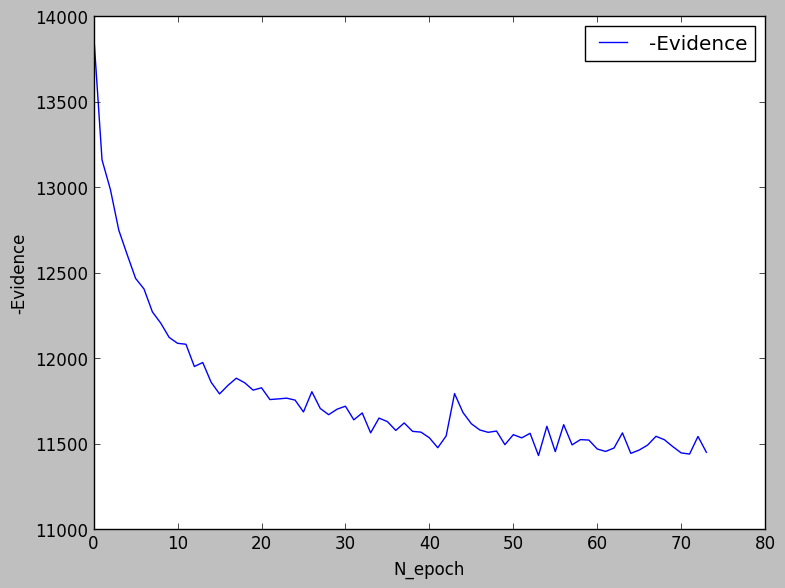

In [49]:
plt.plot(history_evidence)
plt.legend(['-Evidence'])
plt.xlabel('N_epoch')
plt.ylabel('-Evidence')
plt.savefig('Pictures/Evidence_unprunned_'+suffix)
plt.tight_layout()

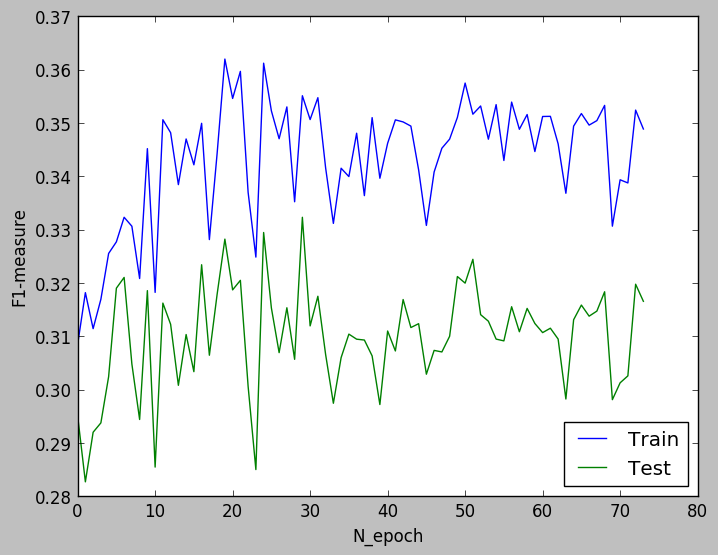

In [50]:
plt.plot(history_score_train)
plt.plot(history_score_test)
plt.legend(['Train','Test'],loc='lower right')
plt.xlabel('N_epoch')
plt.ylabel('F1-measure')
plt.savefig('Pictures/Train_test_score_unprunned_'+suffix)

Загружаем значения весов:

In [84]:
load_weights()

Подсчитываем значение bits для каждого веса матрицы W и U:

In [85]:
bits_W = T.switch(W_mask,(prior_log_sigma - W_var_log_sigma) + ((W_mean-prior_mu)**2+T.exp(2*W_var_log_sigma)-\
    T.exp(2*prior_log_sigma))/(2*T.exp(2*prior_log_sigma)),0)
bits_U = T.switch(U_mask,(prior_log_sigma - U_var_log_sigma) + ((U_mean-prior_mu)**2+T.exp(2*U_var_log_sigma)-\
    T.exp(2*prior_log_sigma))/(2*T.exp(2*prior_log_sigma)),0)

In [86]:
# bits_W = T.switch(W_mask,(prior_log_sigma - var_log_sigma) + ((W_mean-prior_mu)**2 + np.exp(2*var_log_sigma)\
#                               - np.exp(2*prior_log_sigma))/(2*np.exp(2*prior_log_sigma)),0)
# bits_U = T.switch(U_mask,(prior_log_sigma - var_log_sigma) + ((U_mean-prior_mu)**2 + np.exp(2*var_log_sigma)\
#                               - np.exp(2*prior_log_sigma))/(2*np.exp(2*prior_log_sigma)),0)

Вычисляем Bits/weight для полной сети:

In [87]:
bit_per_weight_unprunned = (KLD/N_params).eval()
bit_per_weight_unprunned

array(0.11052288024667017)

Визуалицируем значения bits для матриц W и U с помощью тепловых карт.

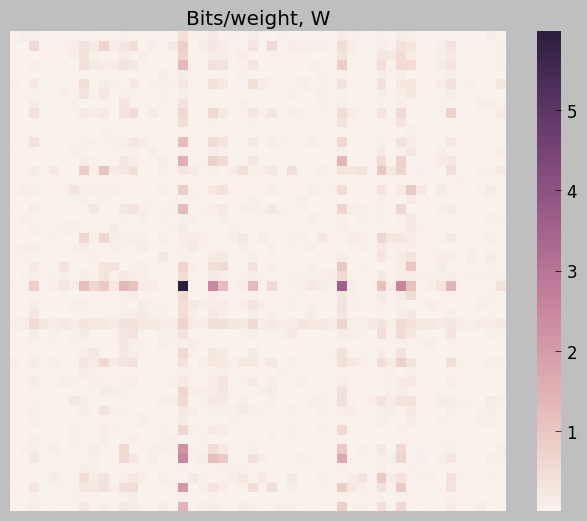

In [55]:
ax = sns.heatmap(bits_W.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Bits/weight, W')
plt.savefig('Pictures/bits_W_unprunned_'+suffix)

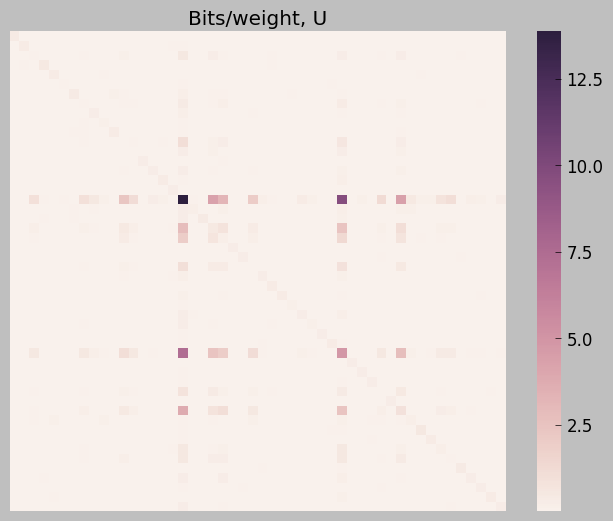

In [56]:
ax = sns.heatmap(bits_U.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Bits/weight, U')
plt.savefig('Pictures/bits_U_unprunned_'+suffix)

Смотрим на распределение самих весов.

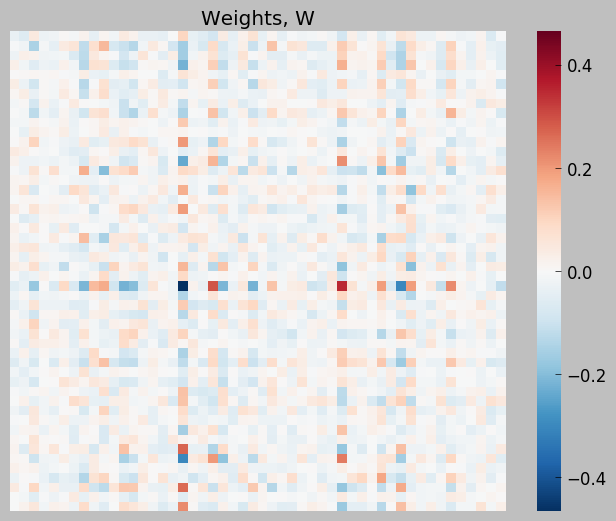

In [60]:
ax = sns.heatmap(W_mean.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Weights, W')
plt.savefig('Pictures/W_matrix_unprunned_'+suffix)

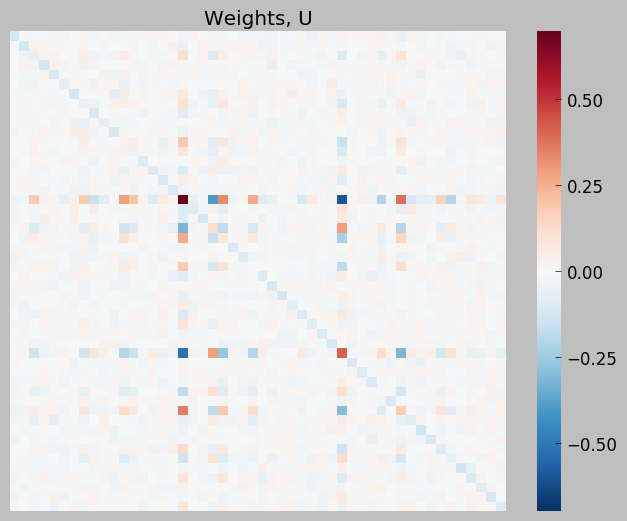

In [61]:
ax = sns.heatmap(U_mean.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
plt.title('Weights, U')
plt.savefig('Pictures/U_matrix_unprunned_'+suffix)

Начинаем прунинг.

Функция, которая по W_mean и var_log_sigma возвращает маску весов.

In [88]:
def pruning_mask(mean_tensor, ld, var_log_sigma):
    mask = T.abs_(mean_tensor/T.exp(var_log_sigma)).eval() >= ld
#     mask = (abs(W_mean.get_value()/np.exp(var_log_sigma.get_value())) >= ld).astype(fx)
    return mask

Cмотрим, сколько весов останется при заданном ld.

In [89]:
N_params_unprunned = N_params.eval()

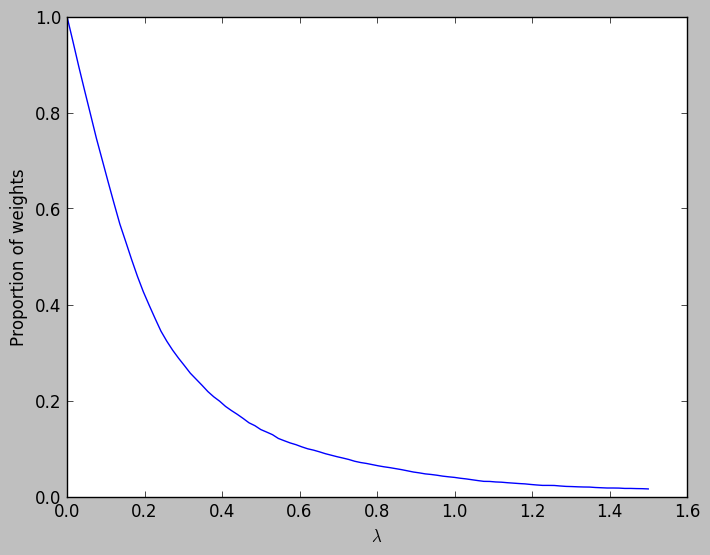

In [90]:
x_range = np.linspace(0,1.5,100)
y = [pruning_mask(mean_tensor,ld,var_log_sigma).sum()/N_params.eval() for ld in x_range]
plt.plot(x_range,y)
plt.xlabel('$\lambda$')
plt.ylabel('Proportion of weights')
plt.savefig('Pictures/Portion_of_pruned_weights_on_lambda_'+suffix+'.pdf')

In [91]:
joblib.dump(y,'History/lambda_'+suffix)

['History/lambda_D_I']

Список различных вариантов для прунинга.

In [92]:
ld_list = [0.05,0.1,0.2,0.4,0.6,0.8,1,1.2,1.4]

Параметры обучения. Создаём таблицу result_df, в которую записываются результаты. Создаём словари, которые будут хранить историю обучения.

In [93]:
unprunned_result = pd.Series(name='unprunned')
unprunned_result['Lambda'] = 0
unprunned_result['Weights_number'] = N_params_unprunned
unprunned_result['Portion_of_weights'] = 1
unprunned_result['Initial_score'] = score_unprunned_test # 0.298214
unprunned_result['Retrain_score'] = score_unprunned_test # 0.298214
# unprunned_result['Initial_score'] = 0.298214
# unprunned_result['Retrain_score'] = 0.298214
unprunned_result['Retrain_epochs'] = 0
unprunned_result['Bits/weight'] = bit_per_weight_unprunned
unprunned_result['Initial_evidence'] = evidence_unprunned # 11891.9
unprunned_result['Retrain_evidence'] = evidence_unprunned # 11891.9
# unprunned_result['Initial_evidence'] = 11891.9
# unprunned_result['Retrain_evidence'] = 11891.9

In [143]:
n_epoches = 200
esr = 20
batch_size = 100
lr.set_value(0.04)
# var_log_sigma.set_value(np.log(0.1).astype(fx))
history_evidence_ld = dict()
history_score_test_ld = dict()
history_score_train_ld = dict()
params_ld = dict()
n_iter = 2

result_df = pd.DataFrame()
result_df = result_df.append(unprunned_result)

average_method = 'weighted'

In [144]:
result_df[['Lambda','Weights_number','Portion_of_weights','Initial_evidence','Retrain_evidence','Initial_score',\
           'Retrain_score','Retrain_epochs','Bits/weight']]

,Lambda,Weights_number,Portion_of_weights,Initial_evidence,Retrain_evidence,Initial_score,Retrain_score,Retrain_epochs,Bits/weight
unprunned,0.0,5706,1.0,11431.274634,11431.274634,0.31282,0.31282,0.0,0.11052288024667017


In [145]:
# def pruning_retrain(ld_list,result_df):
for ld_n, ld in enumerate(ld_list[:]):
#     ld_n = 5
#     if ld_n == 0: continue
#     esr = 30 # при большем прунинге сеть дольше обучается, поэтому увеличиваем esr
#     lr.set_value(np.array(0.01 + 0.005 * ld_n).astype(fx)) # для настойки lr
    history_evidence_tmp = []; history_score_train = []; history_score_test = []
    name = 'ld_'+str(ld)
#     reset_params()
    load_weights()

    mask_new = pruning_mask(mean_tensor,ld,var_log_sigma)
    mask_tensor.set_value(mask_new.astype('float32'))
    
    new_mean = mean_tensor.get_value()
    new_mean[~mask_new] = 0
    mean_tensor.set_value(new_mean.astype(fx))
    
    print('N_params =', N_params.eval())

    initial_predict = np.argmax(predict_fn_det(X_test1, X_test2, M_test1, M_test2), axis=1)
    initial_score = f1_score(Y_test, initial_predict, average=average_method)
    print('initial_score =',initial_score)
    initial_evidence = evidence_fn(X_train1,X_train2,M_train1,M_train2,Y_train)
    retrain_evidence, retrain_score_train, retrain_score_test, retrain_epochs = train(n_epoches, esr,\
        batch_size,average_method=average_method,history_evidence=history_evidence_tmp,\
        history_score_train=history_score_train,history_score_test=history_score_test,border=border)

    bits_per_weigth = (KLD/N_params).eval() # вычисляем Bits/Weight

    result = pd.Series(name=name) # Систематизируем полученные данные
    result['Lambda'] = ld
    result['Weights_number'] = N_params.eval()
    result['Portion_of_weights'] = N_params.eval()/N_params_unprunned
    result['Initial_evidence'] = initial_evidence
    result['Retrain_evidence'] = retrain_evidence
    result['Initial_score'] = initial_score
    result['Retrain_score'] = retrain_score_test
    result['Retrain_epochs'] = retrain_epochs
    result['Bits/weight'] = bits_per_weigth
    result_df = result_df.append(result) # добавляем данные в таблицу

    print('bits_per_weigth =',bits_per_weigth)

#     ax = sns.heatmap(bits_W.eval()) # сохраняем графики
#     ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
#     plt.savefig('Pictures/bits_W_pruned_I_'+name)
#     plt.clf()

#     ax = sns.heatmap(bits_U.eval())
#     ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
#     plt.savefig('Pictures/bits_U_pruned_I_'+name)
#     plt.clf()

    history_evidence_ld.update({name:history_evidence_tmp}); history_score_test_ld.update({name:history_score_test})
    history_score_train_ld.update({name:history_score_train}) # обновляем историю
#     return result_df

N_params = 4751
initial_score = 0.309879939508
Epoch = 0 Evidence =  11301.0 | pls = -2.01 | vls = -2.135 | mu = -0.00582
Train_score = 0.35 | Test_score = 0.32
Epoch = 1 Evidence =  11402.0 | pls = -2.01 | vls = -2.135 | mu = -0.00582
Train_score = 0.355 | Test_score = 0.327
Epoch = 2 Evidence =  11349.0 | pls = -2.01 | vls = -2.136 | mu = -0.00583
Train_score = 0.357 | Test_score = 0.324
Epoch = 3 Evidence =  11446.0 | pls = -2.01 | vls = -2.136 | mu = -0.00581
Train_score = 0.355 | Test_score = 0.319
Epoch = 4 Evidence =  11349.0 | pls = -2.01 | vls = -2.136 | mu = -0.00586
Train_score = 0.356 | Test_score = 0.322
Epoch = 5 Evidence =  11329.0 | pls = -2.01 | vls = -2.137 | mu = -0.00589
Train_score = 0.355 | Test_score = 0.326
Epoch = 6 Evidence =  11401.0 | pls = -2.01 | vls = -2.137 | mu = -0.00591
Train_score = 0.355 | Test_score = 0.332
Epoch = 7 Evidence =  11389.0 | pls = -2.01 | vls = -2.137 | mu = -0.00592
Train_score = 0.35 | Test_score = 0.319
Epoch = 8 Evidence =  11372.

/home/asm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train_score = 0.347 | Test_score = 0.311
Epoch = 2 Evidence =  11205.0 | pls = -1.99 | vls = -2.144 | mu = -0.00717
Train_score = 0.355 | Test_score = 0.319
Epoch = 3 Evidence =  11211.0 | pls = -1.99 | vls = -2.144 | mu = -0.0072
Train_score = 0.354 | Test_score = 0.318
Epoch = 4 Evidence =  11192.0 | pls = -1.99 | vls = -2.144 | mu = -0.00722
Train_score = 0.355 | Test_score = 0.326
Epoch = 5 Evidence =  11199.0 | pls = -1.99 | vls = -2.144 | mu = -0.00723
Train_score = 0.356 | Test_score = 0.329
Epoch = 6 Evidence =  11196.0 | pls = -1.99 | vls = -2.144 | mu = -0.00722
Train_score = 0.358 | Test_score = 0.326
Epoch = 7 Evidence =  11187.0 | pls = -1.99 | vls = -2.144 | mu = -0.00724
Train_score = 0.356 | Test_score = 0.324
Epoch = 8 Evidence =  11194.0 | pls = -1.99 | vls = -2.145 | mu = -0.00728
Train_score = 0.354 | Test_score = 0.322
Epoch = 9 Evidence =  11230.0 | pls = -1.99 | vls = -2.145 | mu = -0.00732
Train_score = 0.355 | Test_score = 0.327
Epoch = 10 Evidence =  11239.0 |

In [146]:
result_df[['Lambda','Weights_number','Portion_of_weights','Initial_evidence','Retrain_evidence','Initial_score',
           'Retrain_score','Retrain_epochs','Bits/weight']]

,Lambda,Weights_number,Portion_of_weights,Initial_evidence,Retrain_evidence,Initial_score,Retrain_score,Retrain_epochs,Bits/weight
unprunned,0.00,5706,1.000000,11431.3,11431.274634,0.312820,0.312820,0.0,0.11052288024667017
ld_0.05,0.05,4751,0.832632,11385.293151855469,11259.786234,0.309880,0.320136,33.0,0.1263550935206075
ld_0.1,0.10,3840,0.672976,11242.116882324219,11107.385304,0.307512,0.333350,33.0,0.14597628911336263
ld_0.2,0.20,2396,0.419909,11031.057342529297,10863.815592,0.304689,0.326281,28.0,0.21122285718710873
ld_0.4,0.40,1111,0.194707,10857.939544677734,10705.996162,0.290850,0.314766,20.0,0.3718663309202014
ld_0.6,0.60,602,0.105503,10831.790054321289,10621.679536,0.278065,0.287594,20.0,0.5250879078608415
ld_0.8,0.80,367,0.064318,10932.76375579834,10527.041513,0.278167,0.301186,28.0,0.6841147939905484
ld_1,1.00,227,0.039783,10959.739379882812,10473.279703,0.277841,0.302372,44.0,0.8857189968293984
ld_1.2,1.20,142,0.024886,11278.261661529541,10550.723184,0.276784,0.291232,39.0,1.050494691015969
ld_1.4,1.40,101,0.017701,11433.521335601807,10597.977929,0.275625,0.287640,53.0,1.2013439518390316


Графики дообучения

In [132]:
# n_iter = 1

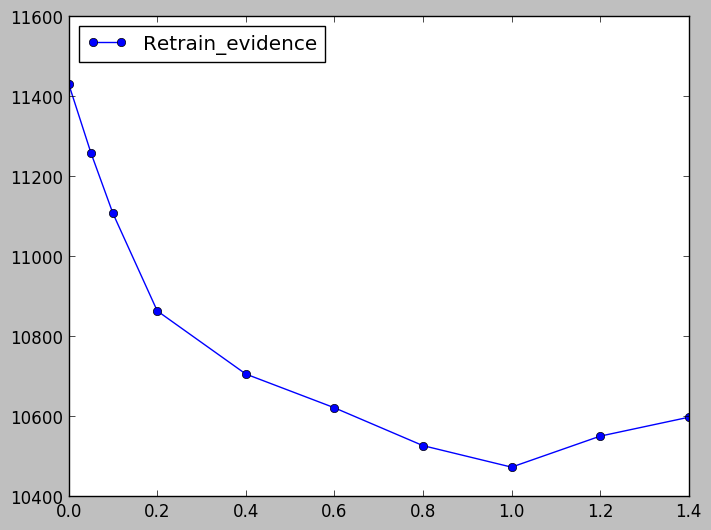

In [148]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_evidence'].values, marker='o')
ax.legend(['Retrain_evidence'],loc='upper left')
plt.savefig('Pictures/evidence_lambda_'+suffix)

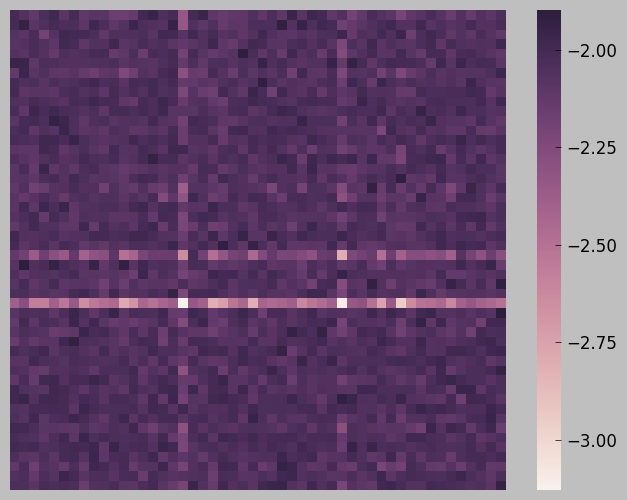

In [149]:
ax = sns.heatmap(W_var_log_sigma.eval())
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)

Смотрим, как изменилась ошибка:

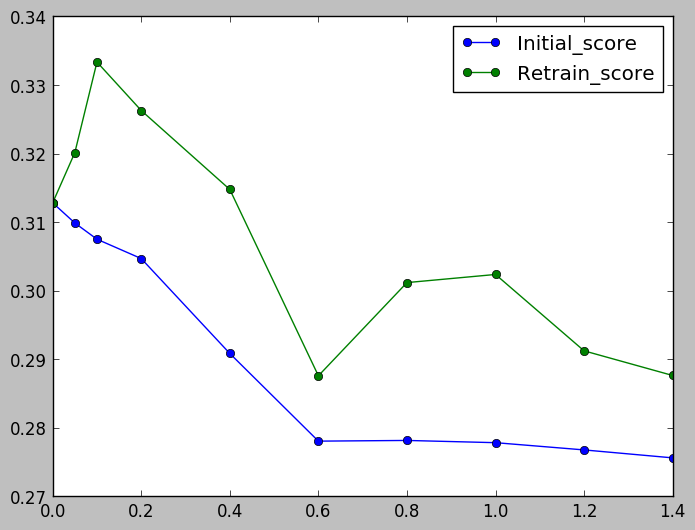

In [150]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Initial_score'].values, marker='o')
line_2, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_score'].values, marker='o')
ax.legend(['Initial_score','Retrain_score'])
plt.savefig('Pictures/lambda_'+suffix+'.pdf')

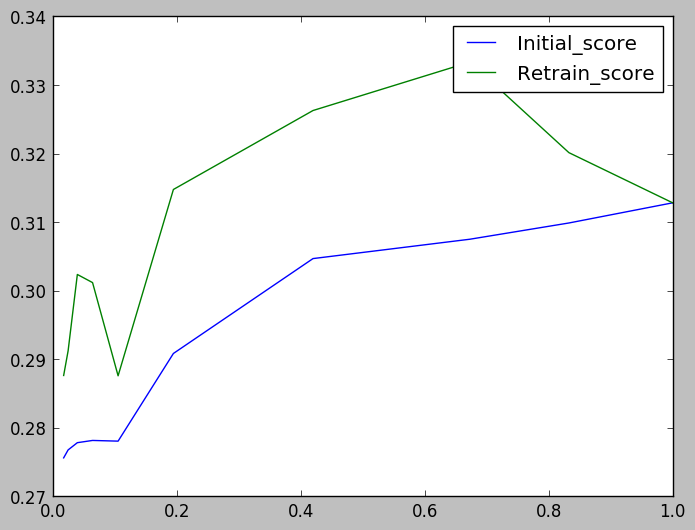

In [151]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Portion_of_weights'].values,result_df.loc[:,'Initial_score'].values)
line_2, = ax.plot(result_df.loc[:,'Portion_of_weights'].values,result_df.loc[:,'Retrain_score'].values)
ax.legend(['Initial_score','Retrain_score'])

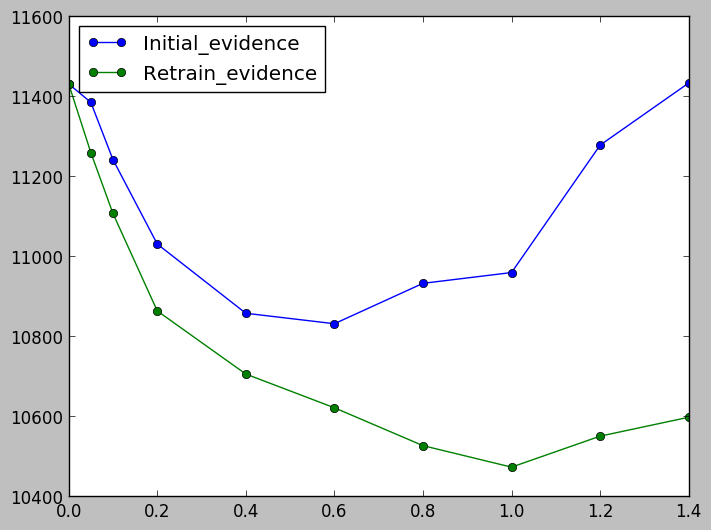

In [152]:
fig, ax = plt.subplots()
line_1, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Initial_evidence'].values, marker='o')
line_2, = ax.plot(result_df.loc[:,'Lambda'].values,result_df.loc[:,'Retrain_evidence'].values, marker='o')
ax.legend(['Initial_evidence','Retrain_evidence'],loc='upper left')
plt.savefig('Pictures/pruning_evidence_'+suffix)

Итоговая таблица:

In [164]:
result_df

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.11052288024667017,11431.3,0.312820,0.00,1.000000,0.0,11431.274634,0.312820,5706
ld_0.05,0.1263550935206075,11385.293151855469,0.309880,0.05,0.832632,33.0,11259.786234,0.320136,4751
ld_0.1,0.14597628911336263,11242.116882324219,0.307512,0.10,0.672976,33.0,11107.385304,0.333350,3840
ld_0.2,0.21122285718710873,11031.057342529297,0.304689,0.20,0.419909,28.0,10863.815592,0.326281,2396
ld_0.4,0.3718663309202014,10857.939544677734,0.290850,0.40,0.194707,20.0,10705.996162,0.314766,1111
ld_0.6,0.5250879078608415,10831.790054321289,0.278065,0.60,0.105503,20.0,10621.679536,0.287594,602
ld_0.8,0.6841147939905484,10932.76375579834,0.278167,0.80,0.064318,28.0,10527.041513,0.301186,367
ld_1,0.8857189968293984,10959.739379882812,0.277841,1.00,0.039783,44.0,10473.279703,0.302372,227
ld_1.2,1.050494691015969,11278.261661529541,0.276784,1.20,0.024886,39.0,10550.723184,0.291232,142
ld_1.4,1.2013439518390316,11433.521335601807,0.275625,1.40,0.017701,53.0,10597.977929,0.287640,101


In [118]:
# n_iter = 1

In [165]:
joblib.dump(result_df, 'History/result_df_'+suffix+'_'+str(n_iter))

['History/result_df_D_I_2']

In [120]:
joblib.dump(history_score_train_ld,'History/history_score_train_ld_'+suffix)
joblib.dump(history_score_test_ld,'History/history_score_test_ld_'+suffix)
joblib.dump(history_evidence_ld,'History/history_evidence_ld_'+suffix)

['History/history_evidence_ld_D_I']

Меняем значения весов и масок в самой нейросети:

In [125]:
result_df_0 = joblib.load('History/result_df_D_I_0')

In [159]:
result_df_0

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.11052288024667017,11431.3,0.312820,0.00,1.000000,0.0,11431.274634,0.312820,5706
ld_0.05,0.12287493340217849,11306.204284667969,0.309880,0.05,0.832632,23.0,11218.736914,0.335902,4751
ld_0.1,0.1425803820292155,11198.425476074219,0.307512,0.10,0.672976,31.0,11101.984330,0.326519,3840
ld_0.2,0.2027207439849293,11071.405975341797,0.304689,0.20,0.419909,38.0,10851.284709,0.330819,2396
ld_0.4,0.3726580849002869,10841.494232177734,0.290850,0.40,0.194707,22.0,10709.939322,0.321127,1111
ld_0.6,0.5282008022168942,10826.888687133789,0.278065,0.60,0.105503,28.0,10544.504562,0.311090,602
ld_0.8,0.7005752022974497,10925.41805267334,0.278167,0.80,0.064318,31.0,10502.364630,0.311382,367
ld_1,0.8778841800101528,10995.663208007812,0.277841,1.00,0.039783,28.0,10500.025668,0.299187,227
ld_1.2,1.0965204910493234,11255.723575592041,0.276784,1.20,0.024886,48.0,10506.343546,0.276794,142
ld_1.4,1.2265238620267056,11438.808444976807,0.275625,1.40,0.017701,43.0,10568.761130,0.286439,101


In [166]:
result_df_1 = joblib.load('History/result_df_D_I_1')

In [167]:
result_df_1

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.11052288024667017,11431.3,0.312820,0.00,1.000000,0.0,11431.274634,0.312820,5706
ld_0.05,0.12350099018011011,11416.310729980469,0.309880,0.05,0.832632,38.0,11204.637195,0.326545,4751
ld_0.1,0.1423210620880127,11260.423522949219,0.307512,0.10,0.672976,48.0,11063.451604,0.331358,3840
ld_0.2,0.21170729189762885,11039.525115966797,0.304689,0.20,0.419909,16.0,10903.182542,0.326987,2396
ld_0.4,0.3669729155532741,10862.860443115234,0.290850,0.40,0.194707,21.0,10689.112986,0.313397,1111
ld_0.6,0.5216561504376687,10838.550796508789,0.278065,0.60,0.105503,19.0,10619.174307,0.290766,602
ld_0.8,0.6915565511511197,10939.16805267334,0.278167,0.80,0.064318,30.0,10525.304946,0.301742,367
ld_1,0.8666813384068695,10938.728637695312,0.277841,1.00,0.039783,28.0,10507.565162,0.291962,227
ld_1.2,1.0683957220802844,11268.674747467041,0.276784,1.20,0.024886,42.0,10549.165750,0.288870,142
ld_1.4,1.1825129065183129,11436.277194976807,0.275625,1.40,0.017701,33.0,10627.134834,0.282471,101


In [168]:
result_df_2 = joblib.load('History/result_df_D_I_2')

In [169]:
result_df_2

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.11052288024667017,11431.3,0.312820,0.00,1.000000,0.0,11431.274634,0.312820,5706
ld_0.05,0.1263550935206075,11385.293151855469,0.309880,0.05,0.832632,33.0,11259.786234,0.320136,4751
ld_0.1,0.14597628911336263,11242.116882324219,0.307512,0.10,0.672976,33.0,11107.385304,0.333350,3840
ld_0.2,0.21122285718710873,11031.057342529297,0.304689,0.20,0.419909,28.0,10863.815592,0.326281,2396
ld_0.4,0.3718663309202014,10857.939544677734,0.290850,0.40,0.194707,20.0,10705.996162,0.314766,1111
ld_0.6,0.5250879078608415,10831.790054321289,0.278065,0.60,0.105503,20.0,10621.679536,0.287594,602
ld_0.8,0.6841147939905484,10932.76375579834,0.278167,0.80,0.064318,28.0,10527.041513,0.301186,367
ld_1,0.8857189968293984,10959.739379882812,0.277841,1.00,0.039783,44.0,10473.279703,0.302372,227
ld_1.2,1.050494691015969,11278.261661529541,0.276784,1.20,0.024886,39.0,10550.723184,0.291232,142
ld_1.4,1.2013439518390316,11433.521335601807,0.275625,1.40,0.017701,53.0,10597.977929,0.287640,101


In [170]:
result_df_all = pd.Panel({'df_0':result_df_0,'df_1':result_df_1,'df_2':result_df_2})

In [171]:
result_df_all.mean(axis=0)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.110523,11431.274634,0.312820,0.00,1.000000,0.000000,11431.274634,0.312820,5706.0
ld_0.05,0.124244,11369.269389,0.309880,0.05,0.832632,31.333333,11227.720114,0.327528,4751.0
ld_0.1,0.143626,11233.655294,0.307512,0.10,0.672976,37.333333,11090.940412,0.330409,3840.0
ld_0.2,0.208550,11047.329478,0.304689,0.20,0.419909,27.333333,10872.760948,0.328029,2396.0
ld_0.4,0.370499,10854.098073,0.290850,0.40,0.194707,21.000000,10701.682823,0.316430,1111.0
ld_0.6,0.524982,10832.409846,0.278065,0.60,0.105503,22.333333,10595.119468,0.296483,602.0
ld_0.8,0.692082,10932.449954,0.278167,0.80,0.064318,29.666667,10518.237030,0.304770,367.0
ld_1,0.876762,10964.710409,0.277841,1.00,0.039783,33.333333,10493.623511,0.297840,227.0
ld_1.2,1.071804,11267.553328,0.276784,1.20,0.024886,43.000000,10535.410827,0.285632,142.0
ld_1.4,1.203460,11436.202325,0.275625,1.40,0.017701,43.000000,10597.957964,0.285517,101.0


In [172]:
result_df_all.std(axis=0)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0
ld_0.05,0.001855,56.775242,0.0,8.498375e-18,0.000000e+00,7.637626,28.650960,0.007929,0.0
ld_0.1,0.002040,31.853388,0.0,1.699675e-17,1.359740e-16,9.291573,23.958685,0.003513,0.0
ld_0.2,0.005054,21.276374,0.0,3.399350e-17,0.000000e+00,11.015141,27.080635,0.002442,0.0
ld_0.4,0.003079,11.189121,0.0,6.798700e-17,0.000000e+00,1.000000,11.062899,0.004125,0.0
ld_0.6,0.003274,5.855707,0.0,0.000000e+00,0.000000e+00,4.932883,43.851689,0.012749,0.0
ld_0.8,0.008243,6.880369,0.0,1.359740e-16,0.000000e+00,1.527525,13.773297,0.005733,0.0
ld_1,0.009568,28.790965,0.0,0.000000e+00,0.000000e+00,9.237604,18.017044,0.005334,0.0
ld_1.2,0.023201,11.310814,0.0,0.000000e+00,0.000000e+00,4.582576,25.185045,0.007745,0.0
ld_1.4,0.022082,2.644350,0.0,2.719480e-16,0.000000e+00,10.000000,29.186857,0.002705,0.0


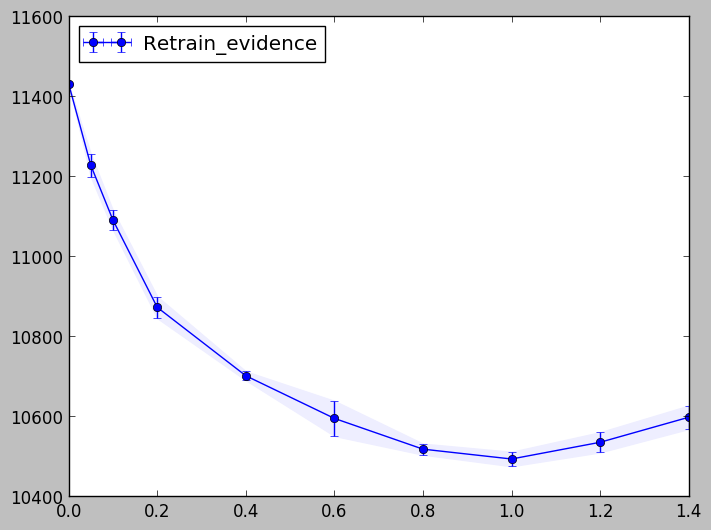

In [173]:
fig, ax = plt.subplots()
# line_1, = ax.plot(result_df_all.mean(axis=0).loc[:,'Lambda'].values,result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values, marker='o')
x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y = result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values
xerr = result_df_all.std(axis=0).loc[:,'Lambda'].values
yerr = result_df_all.std(axis=0).loc[:,'Retrain_evidence'].values

line_1 = ax.errorbar(x=x,y=y,xerr=xerr,yerr=yerr,marker='o')
ax.legend(['Retrain_evidence'],loc='upper left')
ax.fill_between(x, y-yerr, y+yerr,color='#eeeeff')
plt.savefig('Pictures/evidence_lambda_'+suffix)

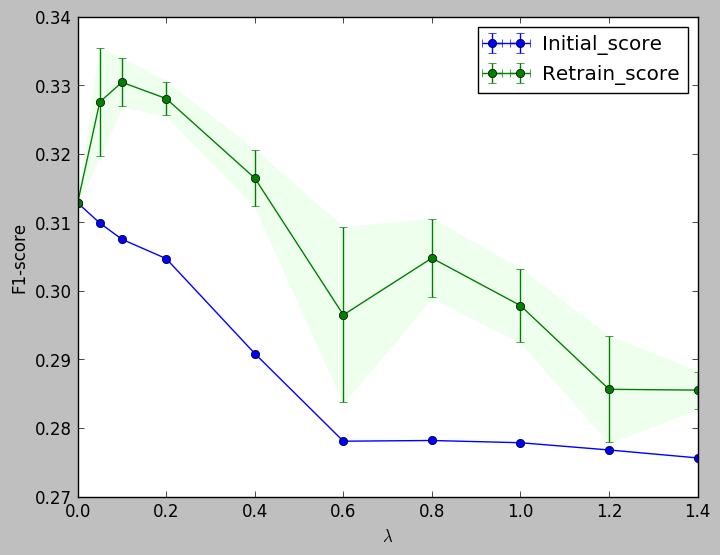

In [174]:
fig, ax = plt.subplots()
x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_score'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_score'].values
x_err = result_df_all.std(axis=0).loc[:,'Lambda'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_score'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_score'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')
ax.legend(['Initial_score','Retrain_score'])

ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('$\lambda$')
plt.ylabel('F1-score')

plt.savefig('Pictures/lambda_'+suffix)

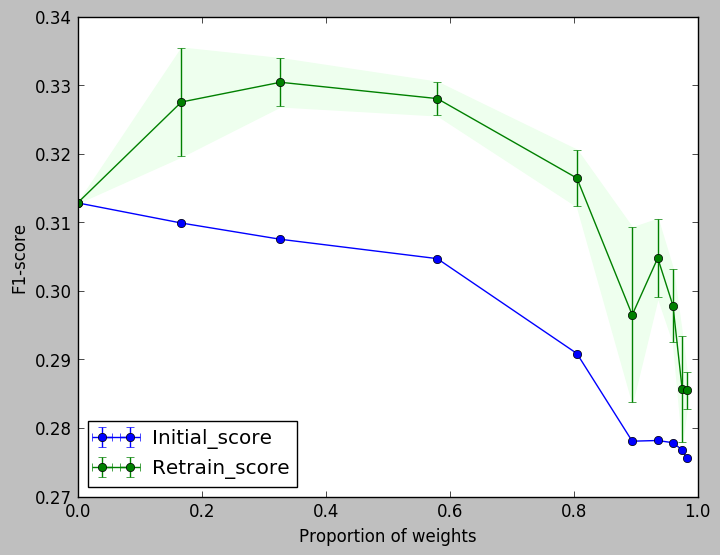

In [175]:
fig, ax = plt.subplots()

x = 1-result_df_all.mean(axis=0).loc[:,'Portion_of_weights'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_score'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_score'].values
x_err = result_df_all.std(axis=0).loc[:,'Portion_of_weights'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_score'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_score'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')

ax.legend(['Initial_score','Retrain_score'],loc='lower left')

ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('Proportion of weights')
plt.ylabel('F1-score')

plt.savefig('Pictures/portion_'+suffix)

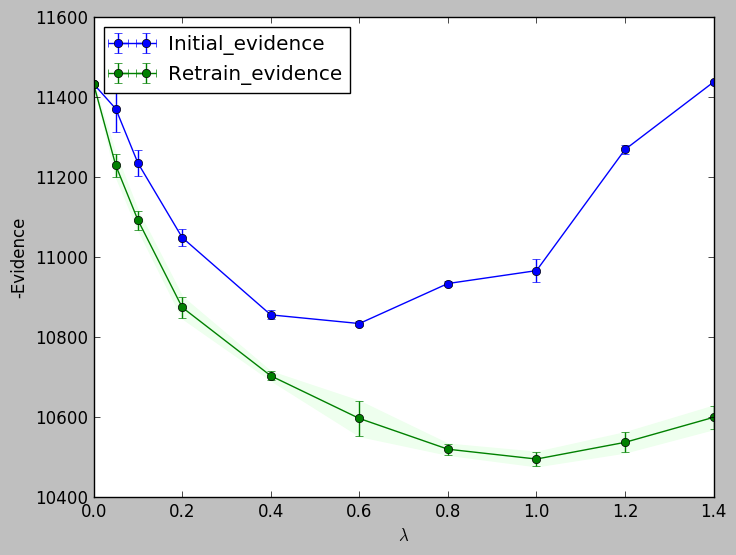

In [176]:
fig, ax = plt.subplots()

x = result_df_all.mean(axis=0).loc[:,'Lambda'].values
y_1 = result_df_all.mean(axis=0).loc[:,'Initial_evidence'].values
y_2 = result_df_all.mean(axis=0).loc[:,'Retrain_evidence'].values
x_err = result_df_all.std(axis=0).loc[:,'Lambda'].values
y_1_err = result_df_all.std(axis=0).loc[:,'Initial_evidence'].values
y_2_err = result_df_all.std(axis=0).loc[:,'Retrain_evidence'].values

line_1 = ax.errorbar(x=x,y=y_1,xerr=x_err,yerr=y_1_err, marker='o')
line_2 = ax.errorbar(x=x,y=y_2,xerr=x_err,yerr=y_2_err, marker='o')

ax.legend(['Initial_evidence','Retrain_evidence'],loc='upper left')
ax.fill_between(x, y_2-y_2_err, y_2+y_2_err,color='#eeffee')

plt.xlabel('$\lambda$')
plt.ylabel('-Evidence')

plt.savefig('Pictures/pruning_evidence_'+suffix)

In [178]:
result_df_all.mean(axis=0)

,Bits/weight,Initial_evidence,Initial_score,Lambda,Portion_of_weights,Retrain_epochs,Retrain_evidence,Retrain_score,Weights_number
unprunned,0.110523,11431.274634,0.312820,0.00,1.000000,0.000000,11431.274634,0.312820,5706.0
ld_0.05,0.124244,11369.269389,0.309880,0.05,0.832632,31.333333,11227.720114,0.327528,4751.0
ld_0.1,0.143626,11233.655294,0.307512,0.10,0.672976,37.333333,11090.940412,0.330409,3840.0
ld_0.2,0.208550,11047.329478,0.304689,0.20,0.419909,27.333333,10872.760948,0.328029,2396.0
ld_0.4,0.370499,10854.098073,0.290850,0.40,0.194707,21.000000,10701.682823,0.316430,1111.0
ld_0.6,0.524982,10832.409846,0.278065,0.60,0.105503,22.333333,10595.119468,0.296483,602.0
ld_0.8,0.692082,10932.449954,0.278167,0.80,0.064318,29.666667,10518.237030,0.304770,367.0
ld_1,0.876762,10964.710409,0.277841,1.00,0.039783,33.333333,10493.623511,0.297840,227.0
ld_1.2,1.071804,11267.553328,0.276784,1.20,0.024886,43.000000,10535.410827,0.285632,142.0
ld_1.4,1.203460,11436.202325,0.275625,1.40,0.017701,43.000000,10597.957964,0.285517,101.0


In [179]:
pd.(result_df_all,'result_df_all')

AttributeError: module 'pandas' has no attribute 'to_csv'

In [180]:
result_df_all.to_excel('result_df_all.xlsx')